In [1]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
def extract_gene_data(h5ad_path, gene_name='Xist', layer=None):
    adata = anndata.read_h5ad(h5ad_path)

    # Validate gene existence
    if gene_name not in adata.var_names:
        missing_genes = set([gene_name]) - set(adata.var_names)
        raise ValueError(f"Gene(s) not found: {missing_genes}")

    # Get expression values
    gene_idx = adata.var_names.get_loc(gene_name)
    matrix = adata.layers[layer] if layer else adata.X
    expression = matrix[:, gene_idx]

    # Add explicit cell ID column
    combined_df = adata.obs.copy()
    combined_df['id'] = adata.obs.index  # Explicit cell barcodes
    combined_df['expression'] = expression.toarray().flatten() if issparse(expression) else expression

    # Add gene metadata
    for col, value in adata.var.loc[gene_name].items():
        combined_df[f'gene_{col}'] = value

    return combined_df



def save_gene_names(h5ad_path, output_file="gene_names.txt"):
    """
    Extract all gene names from an H5AD file and save them to a text file.

    Parameters:
    h5ad_path (str): Path to the H5AD file
    output_file (str): Name of the output text file (default: 'gene_names.txt')

    Returns:
    str: Path to the saved text file
    """
    # Read the H5AD file
    adata = anndata.read_h5ad(h5ad_path)

    # Extract gene names
    gene_names = adata.var_names.tolist()

    # Determine the output directory (same as H5AD file)
    output_dir = os.path.dirname(h5ad_path)
    output_path = os.path.join(output_dir, output_file)

    # Write gene names to the text file
    with open(output_path, "w") as f:
        for gene in gene_names:
            f.write(f"{gene}\n")

    print(f"Gene names saved to: {output_path}")
    print(f"Total genes: {len(gene_names)}")

    return output_path


# Example usage:
# save_gene_names("path/to/your/file.h5ad")

In [34]:
folder = "/Volumes/guttman/Guoming_Gao-Resnick/swift_seq/Alexs_1b_reads_4conditions"
os.chdir(folder)
df_A_all = extract_gene_data("ConditionA-GeneFull-StarSolo-all.h5ad", "Xist")
df_B_all = extract_gene_data("ConditionB-GeneFull-StarSolo-all.h5ad", "Xist")
df_C_all = extract_gene_data("ConditionC-GeneFull-StarSolo-all.h5ad", "Xist")
df_D_all = extract_gene_data("ConditionD-GeneFull-StarSolo-all.h5ad", "Xist")

In [35]:
df_A_all.keys()

Index(['id', 'cell_counts', 'n_genes', 'percent_mito', 'expression',
       'gene_gene_id', 'gene_gene_name', 'gene_gene_counts', 'gene_n_cells'],
      dtype='object')

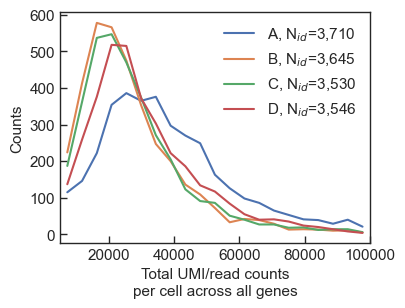

In [64]:
# cell_counts: Represents the total UMI/read counts per cell across all genes.
x_min = 5000
x_max = 100000
cname = "cell_counts"
dfa = df_A_all[cname]
dfb = df_B_all[cname]
dfc = df_C_all[cname]
dfd = df_D_all[cname]
hist_A, bins_edge = np.histogram(dfa, bins=21, range=(x_min, x_max), density=False)
hist_B, bins_edge = np.histogram(dfb, bins=21, range=(x_min, x_max), density=False)
hist_C, bins_edge = np.histogram(dfc, bins=21, range=(x_min, x_max), density=False)
hist_D, bins_edge = np.histogram(dfd, bins=21, range=(x_min, x_max), density=False)
midpoints = (bins_edge[:-1] + bins_edge[1:]) / 2
plt.figure(figsize=(4, 3))
plt.plot(midpoints, hist_A, label=r"A, N$_{id}$=" + f"{np.sum(dfa>x_min):,}")
plt.plot(midpoints, hist_B, label=r"B, N$_{id}$=" + f"{np.sum(dfb>x_min):,}")
plt.plot(midpoints, hist_C, label=r"C, N$_{id}$=" + f"{np.sum(dfc>x_min):,}")
plt.plot(midpoints, hist_D, label=r"D, N$_{id}$=" + f"{np.sum(dfd>x_min):,}")
plt.xlim(x_min, x_max)
# plt.yscale('log')
plt.legend(frameon=False)
# adjust
plt.xlabel('Total UMI/read counts\nper cell across all genes', fontsize=11)
# plt.ylabel(r"Probability Density", fontsize=11)
plt.ylabel(r"Counts", fontsize=11)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=11,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.savefig("hist_cell_counts_across_4_conditions.png", format="png", dpi=300)

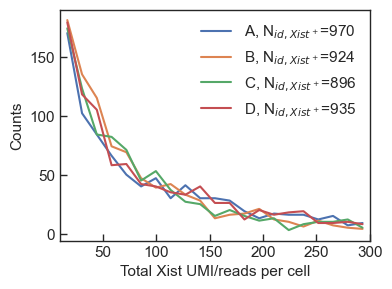

In [67]:
# cell_counts: Represents the total UMI/read counts per cell across all genes.
x_min = 10
x_max = 300
cname = "expression"
dfa = df_A_all[df_A_all[cname] > 0][cname]
dfb = df_B_all[df_B_all[cname] > 0][cname]
dfc = df_C_all[df_C_all[cname] > 0][cname]
dfd = df_D_all[df_D_all[cname] > 0][cname]
hist_A, bins_edge = np.histogram(dfa, bins=21, range=(x_min, x_max))
hist_B, bins_edge = np.histogram(dfb, bins=21, range=(x_min, x_max))
hist_C, bins_edge = np.histogram(dfc, bins=21, range=(x_min, x_max))
hist_D, bins_edge = np.histogram(dfd, bins=21, range=(x_min, x_max))
midpoints = (bins_edge[:-1] + bins_edge[1:]) / 2
plt.figure(figsize=(4, 3))
plt.plot(midpoints, hist_A, label=r"A, N$_{id,Xist^+}$=" + f"{np.sum(dfa>x_min):,}")
plt.plot(midpoints, hist_B, label=r"B, N$_{id,Xist^+}$=" + f"{np.sum(dfb>x_min):,}")
plt.plot(midpoints, hist_C, label=r"C, N$_{id,Xist^+}$=" + f"{np.sum(dfc>x_min):,}")
plt.plot(midpoints, hist_D, label=r"D, N$_{id,Xist^+}$=" + f"{np.sum(dfd>x_min):,}")
plt.xlim(x_min, x_max)
# plt.yscale('log')
plt.legend(frameon=False)
# adjust
plt.xlabel(r"Total Xist UMI/reads per cell", fontsize=11)
plt.ylabel(r"Counts", fontsize=11)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=11,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.savefig("hist_Xist_expression_across_4_conditions.png", format="png", dpi=300)

In [29]:
df_A_all[cname]

AAAAAAAAAAAAAAAAAAAA    0.0
AAAAAAAAAAAAAAAAAAAC    0.0
AAAAAAAAAAAAAAAAAAAT    0.0
AAAAAAAAAAAAAAAAAACA    0.0
AAAAAAAAAAAAAAAAAACG    0.0
                       ... 
AAAAAAAAAATCTACTCGGT    0.0
AAAAAAAAAATCTACTCGTG    0.0
AAAAAAAAAATCTACTGATA    0.0
AAAAAAAAAATCTACTGCAC    0.0
AAAAAAAAAATCTACTGGAA    0.0
Name: expression, Length: 143496, dtype: float32